In [34]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [35]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'

# 分類数設定

In [36]:
NUM_CLASSES = 8

# 学習データ読み込み

In [37]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [38]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [41]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 8)                 88        
                                                                 
Total params: 1,158
Trainable params: 1,158
Non-trainable params: 0
_________________________________________________________________


In [42]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [43]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [44]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/37 [..............................] - ETA: 7s - loss: 2.2053 - accuracy: 0.1562
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
37/37 [==============================] - 0s 3ms/step - loss: 2.0608 - accuracy: 0.1831 - val_loss: 1.9251 - val_accuracy: 0.2451
Epoch 2/1000
 1/37 [..............................] - ETA: 0s - loss: 1.9893 - accuracy: 0.1875
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
37/37 [==============================] - 0s 1ms/step - loss: 1.8977 - accuracy: 0.2575 - val_loss: 1.7615 - val_accuracy: 0.2977
Epoch 3/1000
 1/37 [..............................] - ETA: 0s - loss: 1.7567 - accuracy: 0.3594
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
37/37 [==============================] - 0s 1ms/step - loss: 1.7742 - accuracy: 0.2933 - val_loss: 1.6418 - val_accuracy: 0.3541
Epoch 4/1000
 1/37 [..............................] - ETA: 0s - loss: 1.7267 - accuracy: 0.359

In [45]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

13/13 [==============================] - 0s 410us/step - loss: 0.4279 - accuracy: 0.8975


In [46]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [47]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 22ms/step
[6.1106380e-02 7.4607611e-01 1.9080898e-01 9.4117422e-05 1.2007229e-03
 9.6012764e-06 1.2410717e-05 6.9171103e-04]
1


# 混同行列

49/49 [==============================] - 0s 251us/step


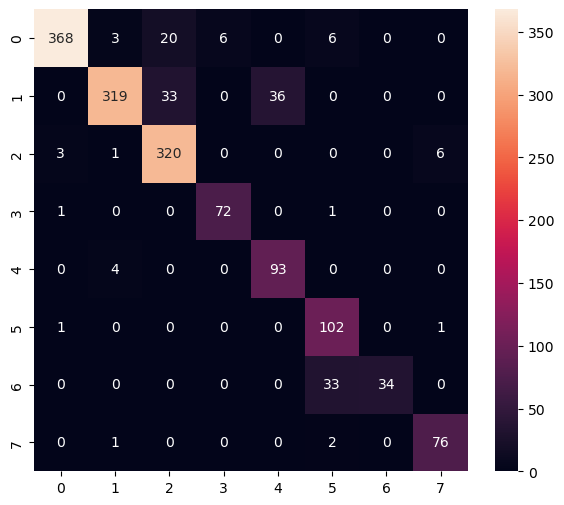

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       403
           1       0.97      0.82      0.89       388
           2       0.86      0.97      0.91       330
           3       0.92      0.97      0.95        74
           4       0.72      0.96      0.82        97
           5       0.71      0.98      0.82       104
           6       1.00      0.51      0.67        67
           7       0.92      0.96      0.94        79

    accuracy                           0.90      1542
   macro avg       0.89      0.89      0.87      1542
weighted avg       0.91      0.90      0.90      1542



In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [49]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [50]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/kd/rkdh2ckn6y313ps39rr1p3p80000gn/T/tmpyujconnl/assets


INFO:tensorflow:Assets written to: /var/folders/kd/rkdh2ckn6y313ps39rr1p3p80000gn/T/tmpyujconnl/assets
2024-12-15 18:04:44.210979: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-12-15 18:04:44.211174: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-12-15 18:04:44.212151: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/kd/rkdh2ckn6y313ps39rr1p3p80000gn/T/tmpyujconnl
2024-12-15 18:04:44.213047: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-12-15 18:04:44.213052: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/kd/rkdh2ckn6y313ps39rr1p3p80000gn/T/tmpyujconnl
2024-12-15 18:04:44.216679: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-12-15 18:04:44.245477: I tensorflow/cc/saved_model/loader.cc:213] Running initialization

6748

# 推論テスト

In [51]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


In [52]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [53]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [54]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 309 μs, sys: 451 μs, total: 760 μs
Wall time: 476 μs


In [55]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.11063391e-02 7.46076167e-01 1.90808907e-01 9.41173348e-05
 1.20072125e-03 9.60126818e-06 1.24107055e-05 6.91710040e-04]
1
